In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import meerkat as mk
import glob
import os
import numpy as np
import pandas as pd
import json
from tqdm.std import tqdm

In [3]:
import ujson as json

In [4]:
dataset_dir = "/home/common/datasets/visual-genome"

In [83]:
with open(f'/home/common/datasets/visual-genome/attributes.json') as f:
    objects = json.load(f)

In [22]:
objects_dp = []
attributes_dp = []
for image in tqdm(objects):
    for obj in image["attributes"]:
        obj["image_id"] = image["image_id"]
        # all names are length 1
        names = obj.pop("names")
        attributes = obj.pop("attributes", None)
        if attributes is not None:
            for attribute in attributes:
                attributes_dp.append({"object_id": obj["object_id"], "attribute": attribute})
        obj["name"] = names[0]
        synset = obj.pop("synsets")
        obj["syn_name"] = synset[0] if len(synset) > 0 else ""
        objects_dp.append(obj)
object_dp = mk.DataPanel(objects_dp)

100%|██████████| 108077/108077 [00:05<00:00, 20311.45it/s]


In [33]:
with open(f'/home/common/datasets/visual-genome/image_data.json') as f:
    images = json.load(f)
image_dp = mk.DataPanel(images)
image_dp.remove_column("coco_id")
image_dp.remove_column("flickr_id")

image_dp["local_path"] = dataset_dir + (
    image_dp["url"].str.split("rak248")
).apply(lambda x: x[-1])

image_dp["image"] = mk.ImageColumn(image_dp["local_path"])

In [34]:
merged_dp = image_dp.merge(object_dp, on="image_id")

In [24]:
merged_dp.write("merged_vg_dp.mk")

In [14]:
data = np.array(list(map(len, object_dp["synsets"])))

In [26]:
attributes_dp = mk.DataPanel(attributes_dp)

In [52]:
green_dp = attributes_dp[attributes_dp["attribute"]== "red"]

In [53]:
dp = merged_dp.merge(green_dp, on="object_id")

{'object_id': 1626883, 'image_id': 1103, 'height': 600, 'url': 'https://cs.stanford.edu/people/rak248/VG_100K_2/1103.jpg', 'width': 800, 'index': '21680', 'local_path': '/home/common/datasets/visual-genome/VG_100K_2/1103.jpg', 'image': <PIL.Image.Image image mode=RGB size=800x600 at 0x7F8D445DFEB0>, 'h': 106, 'name': 'table', 'syn_name': 'table.n.02', 'w': 198, 'x': 80, 'y': 393, 'attribute': 'red'}


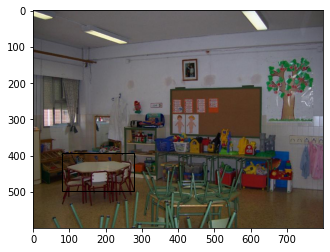

In [67]:
row = dp[1000]
print(row)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots()

ax.imshow(row["image"])
ax.add_patch(patches.Rectangle((row["x"], row["y"]), row["w"], row["h"], edgecolor="black", facecolor='none'))

In [45]:
merged_dp.write("merged_vg_dp.mk")

In [47]:
new_dp = mk.DataPanel.read("merged_vg_dp.mk")

In [68]:
with open(f'/home/common/datasets/visual-genome/relationships.json') as f:
    relationships = json.load(f)

In [79]:
rel_dp = []
for image in relationships:
    image_id = image["image_id"]
    for r in image["relationships"]:
        object_synset = r["object"]["synsets"]
        subject_synset = r["subject"]["synsets"]
    
        rel_dp.append({
            "image_id": image_id,
            "predicate": r["predicate"],
            "subject_object_id": r["subject"]["object_id"],
            "subject_name": r["subject"]["name"] if "name" in r["subject"] else r["subject"]["names"][0],
            "subject_syn": subject_synset[0] if len(subject_synset) > 0 else "",
            "object_object_id": r["object"]["object_id"],
            "object_name": r["object"]["name"] if "name" in r["object"] else r["object"]["names"][0],
            "object_syn": object_synset[0] if len(object_synset) > 0 else "",
        })
rel_dp = mk.DataPanel(rel_dp)

In [80]:
rel_dp

,image_id (NumpyArrayColumn),object_name (PandasSeriesColumn),object_object_id (NumpyArrayColumn),object_syn (PandasSeriesColumn),predicate (PandasSeriesColumn),subject_name (PandasSeriesColumn),subject_object_id (NumpyArrayColumn),subject_syn (PandasSeriesColumn),index (PandasSeriesColumn)
0,1,sidewalk,1058534,sidewalk.n.01,ON,shade,5045,shade.n.01,0
1,1,shoes,1058525,shoe.n.01,wears,man,1058529,man.n.01,1
2,1,headlight,5050,headlight.n.01,has,car,5049,car.n.01,2
3,1,building,1058508,building.n.01,ON,sign,1058507,sign.n.02,3
4,1,sidewalk,1058534,sidewalk.n.01,ON,tree trunk,5055,trunk.n.01,4
...,...,...,...,...,...,...,...,...,...
2316099,2417997,bus,3103225,bus.n.01,ON,plate,3786799,plate.n.04,2316099
2316100,2417997,desert,3786800,desert.n.01,IN,bus,3103225,bus.n.01,2316100
2316101,2417997,road,3103226,road.n.01,ON,bus,3103225,bus.n.01,2316101
2316102,2417997,doors,2712437,door.n.01,with,bus,3103225,bus.n.01,2316102


In [87]:
x = np.array(list(len(obj["synsets"]) for image in objects for obj in image["attributes"]))

In [8]:
from meerkat.contrib.visual_genome import build_visual_genome_dps, read_visual_genome_dps, write_visual_genome_dps

In [6]:
%%time
dps = build_visual_genome_dps(dataset_dir)

Loading objects and attributes...
Loading images...
Loading relationships...
CPU times: user 1min 45s, sys: 6.43 s, total: 1min 51s
Wall time: 1min 54s


In [9]:
write_visual_genome_dps(dps, dataset_dir)

In [16]:
dps = read_visual_genome_dps(dataset_dir)

CPU times: user 5.3 s, sys: 1.13 s, total: 6.43 s
Wall time: 6.09 s


In [41]:
dp = dps["images"].merge(dps["objects"], on="image_id")
attr_dp = dps["attributes"]
skiers = attr_dp.lz[attr_dp["attribute"] == "skiing"].merge(dp, on="object_id")

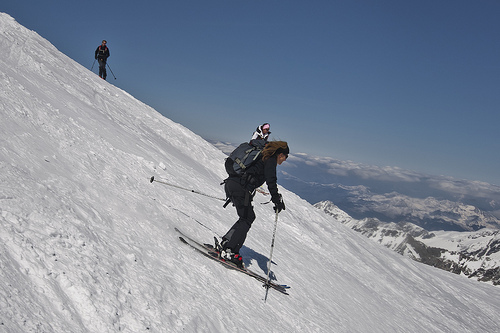

In [45]:
skiers["image"][1000]

In [27]:
dp.lz[dp['name'] == "man"]

,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn)
0,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,3,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,262,man,1058529,man.n.01,60,238,249
1,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,20,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,251,man,1058532,man.n.01,75,372,264
2,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,34,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,248,man,3798576,man.n.01,97,362,264
3,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,35,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,264,man,3798577,man.n.01,72,230,251
4,2,600,https://cs.stanford.edu/people/rak248/VG_100K/...,800,42,/home/common/datasets/visual-genome/VG_100K/2.jpg,ImageCell(/home/common/datasets/visual-genome/...,255,man,1023838,man.n.01,142,324,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93957,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802240,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,368,man,3381367,man.n.01,86,136,90
93958,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802244,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,360,man,2932846,man.n.01,147,112,85
93959,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802254,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,229,man,3786795,man.n.01,134,130,76
93960,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802262,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,361,man,3448870,man.n.01,102,134,88


In [31]:
attr_dp.lz[attr_dp["attribute"] == "skiing"]

,attribute (PandasSeriesColumn),object_id (NumpyArrayColumn),index (PandasSeriesColumn)
0,skiing,145510,92991
1,skiing,145164,93283
2,skiing,145167,93286
3,skiing,1037380,96160
4,skiing,3967432,96369
...,...,...,...
1699,skiing,3786225,2334233
1700,skiing,3786224,2334234
1701,skiing,3410128,2335998
1702,skiing,4287845,2340975


In [65]:
person_dp = dp.lz[dp["syn_name"].isin(["man.n.01", "person.n.01", "woman.n.01"])]
skier_dp = attr_dp.lz[attr_dp["attribute"] == "skiing"].merge(person_dp, on="object_id")

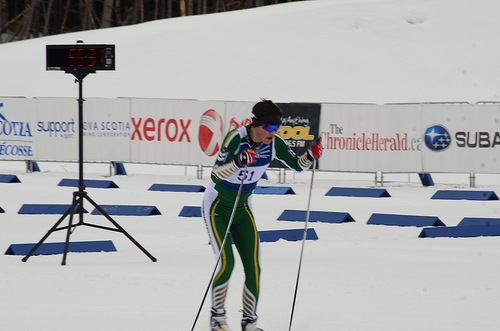

In [66]:
skier_dp["image"][100]

In [67]:
skier_dp

,object_id (NumpyArrayColumn),attribute (PandasSeriesColumn),index (PandasSeriesColumn),image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn)
0,145510,skiing,172105,2415123,236,https://cs.stanford.edu/people/rak248/VG_100K_...,500,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,118,man,man.n.01,91,375,75
1,145164,skiing,172517,2415141,500,https://cs.stanford.edu/people/rak248/VG_100K_...,375,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,219,man,man.n.01,105,50,208
2,145167,skiing,172520,2415141,500,https://cs.stanford.edu/people/rak248/VG_100K_...,375,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,303,person,person.n.01,129,154,169
3,1059969,skiing,176927,61600,482,https://cs.stanford.edu/people/rak248/VG_100K/...,1024,/home/common/datasets/visual-genome/VG_100K/61...,ImageCell(/home/common/datasets/visual-genome/...,347,man,man.n.01,378,247,67
4,1568108,skiing,189789,285612,638,https://cs.stanford.edu/people/rak248/VG_100K/...,960,/home/common/datasets/visual-genome/VG_100K/28...,ImageCell(/home/common/datasets/visual-genome/...,222,person,person.n.01,80,575,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,3181129,skiing,3757792,2416733,333,https://cs.stanford.edu/people/rak248/VG_100K_...,500,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,160,person,person.n.01,150,241,127
933,3508880,skiing,3757793,2416733,333,https://cs.stanford.edu/people/rak248/VG_100K_...,500,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,100,person,person.n.01,80,267,151
934,3040142,skiing,3757794,2416733,333,https://cs.stanford.edu/people/rak248/VG_100K_...,500,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,9,person,person.n.01,22,446,93
935,2704486,skiing,3757795,2416733,333,https://cs.stanford.edu/people/rak248/VG_100K_...,500,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,155,person,person.n.01,100,263,136


In [48]:
dp.lz[dp['name'] == "man"]

,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn)
0,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,3,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,262,man,1058529,man.n.01,60,238,249
1,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,20,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,251,man,1058532,man.n.01,75,372,264
2,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,34,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,248,man,3798576,man.n.01,97,362,264
3,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,35,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,264,man,3798577,man.n.01,72,230,251
4,2,600,https://cs.stanford.edu/people/rak248/VG_100K/...,800,42,/home/common/datasets/visual-genome/VG_100K/2.jpg,ImageCell(/home/common/datasets/visual-genome/...,255,man,1023838,man.n.01,142,324,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93957,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802240,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,368,man,3381367,man.n.01,86,136,90
93958,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802244,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,360,man,2932846,man.n.01,147,112,85
93959,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802254,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,229,man,3786795,man.n.01,134,130,76
93960,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802262,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,361,man,3448870,man.n.01,102,134,88


In [49]:
"man.n.01" dp["syn_name"].value_counts()

array(['clock.n.01', 'street.n.01', 'shade.n.01', ..., 'ripple_mark.n.01',
       'redskin.n.01', 'whitehead.n.01'], dtype=object)

In [52]:
dp["syn_name"].value_counts()[:30]

,(PandasSeriesColumn)
,843545
man.n.01,81057
window.n.01,62874
tree.n.01,60672
person.n.01,56964
shirt.n.01,42398
building.n.01,38765
wall.n.01,37879
sign.n.02,37253
sky.n.01,36185


In [55]:
person_dp = dp.lz[dp["syn_name"].isin(["man.n.01", "person.n.01", "woman.n.01"])]

In [56]:
person_dp

,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn)
0,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,3,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,262,man,1058529,man.n.01,60,238,249
1,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,20,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,251,man,1058532,man.n.01,75,372,264
2,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,34,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,248,man,3798576,man.n.01,97,362,264
3,1,600,https://cs.stanford.edu/people/rak248/VG_100K_...,800,35,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,264,man,3798577,man.n.01,72,230,251
4,2,600,https://cs.stanford.edu/people/rak248/VG_100K/...,800,42,/home/common/datasets/visual-genome/VG_100K/2.jpg,ImageCell(/home/common/datasets/visual-genome/...,255,man,1023838,man.n.01,142,324,320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173855,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802240,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,368,man,3381367,man.n.01,86,136,90
173856,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802244,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,360,man,2932846,man.n.01,147,112,85
173857,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802254,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,229,man,3786795,man.n.01,134,130,76
173858,2417993,500,https://cs.stanford.edu/people/rak248/VG_100K_...,500,3802262,/home/common/datasets/visual-genome/VG_100K_2/...,ImageCell(/home/common/datasets/visual-genome/...,361,man,3448870,man.n.01,102,134,88
